# Notebook 07: Proposal Order Amounts

This notebook generates sales orders for the 2022H3 proposal using forecasting and regression predictions generated in [Notebook 4: Forecasting Monthly](04_Forecasting_Monthly.ipynb) and [Notebook 6: Classification Predicting Sales For New Models](05_Classification_Predict_Sales.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_error
    
from custom_functions import *
from regression_custom_functions import *

In [2]:
# Import datasets and predictions
df_proposal = pd.read_csv('../data/cleaned_datasets/df_models.csv')
proposal_predictions = pd.read_csv('../data/predictions/proposal_forecast.csv')
new_model_predictions = pd.read_csv('../data/predictions/new_models_classifications.csv')

# Drop items not on proposal
df_proposal.dropna(subset='proposal_priority',inplace=True)

# Get names of columns for predictions
proposal_preds_column = proposal_predictions.columns[1]
new_model_preds_column = new_model_predictions.columns[1]

In [3]:
return_nondate_col(df_proposal).columns

Index(['style_id', 'max_cart_qty', 'availability', 'qty_on_hand',
       'qty_on_order', 'qty_total_inv', 'qty_sold_last_6m', 'qty_avg/mo',
       'months_of_supply', 'xyz_cost', 'qty_xyz_cost', 'wholesale_price',
       'country_of_origin', 'warranty', 'band_color', 'band_material',
       'case_material', 'dial_color', 'case_size', 'gender', 'color',
       'retail_price', 'collection', 'clasp_type', 'water_resistance',
       'movement_type', 'proposal_priority', 'status', 'planned_order'],
      dtype='object')

In [4]:
order_sheet_columns = ['style_id','proposal_priority', 'availability', 
       'max_cart_qty', 'retail_price', 'wholesale_price','xyz_cost','qty_total_inv', 'planned_order']

In [5]:
order_sheet = df_proposal[order_sheet_columns]

## Create new dataframe that merges proposal, proposal forecast, new models, and new model predictions to create an overall order.

In [6]:
order_sheet = order_sheet.merge(proposal_predictions, how = 'left', on = 'style_id')
order_sheet = order_sheet.merge(new_model_predictions, how = 'left', on = 'style_id')

In [7]:
def preds_to_order(order_sheet, order_multiple, class_multiple = 1):
    """ This function generates orders from the forecasts from old models and the predictions for new models.
    
    args:
        order_sheet (Pandas dataframe): a dataframe that contains a new_model_preds_columns and proposal_preds_column (both variables)
        and a qty_total_inv column
        order_multiple (int): an integer that defines the quantity to which a proposal prediction is rounded up
        class_multiple (int), optional: the value to multiply the class value by to generate an order (only applicable for classification).
                                        Default is 1 to handle regression cases.
    """
    order_sheet['quarterly_forecast'] = 0
    order_sheet['order_quantity'] = 0

    for i in order_sheet.index:
        base = order_multiple
        if str(order_sheet.loc[i,proposal_preds_column]) == "nan":
            quarterly = class_multiple * order_sheet.loc[i,new_model_preds_column]
            order = quarterly
        else:
            quarterly = 3 * order_sheet.loc[i,proposal_preds_column]
            order = quarterly - order_sheet.loc[i,'qty_total_inv']
            if order < 0:
                order = 0
        order_sheet.loc[i,'quarterly_forecast'] = round(quarterly)
        order_sheet.loc[i,'order_quantity'] = base * round(order/base)

In [8]:
preds_to_order(order_sheet, 5, 10)

In [9]:
order_sheet

,style_id,proposal_priority,availability,max_cart_qty,retail_price,wholesale_price,xyz_cost,qty_total_inv,planned_order,monthly_forecast_Q3,monthly_classifications_Q3,quarterly_forecast,order_quantity
0,ce1107,c,available,100,219.0,109.5,76.65,12.0,10.0,5.537037,NaN,17,5
1,ce1108,c,available,100,219.0,109.5,76.65,17.0,0.0,2.259259,NaN,7,0
2,ce1111,c,available,100,230.0,115.0,80.50,0.0,10.0,0.000000,NaN,0,0
3,ce1112,c,available,100,219.0,109.5,76.65,8.0,5.0,3.666667,NaN,11,5
4,ce1113,c,available,100,219.0,109.5,76.65,14.0,5.0,4.333333,NaN,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,fs5949,2022h3,delivery more than 6 weeks,NaN,155.0,77.5,54.25,0.0,50.0,NaN,3.0,30,30
296,fs5950,2022h3,delivery more than 6 weeks,NaN,155.0,77.5,54.25,0.0,40.0,NaN,5.0,50,50
297,fs5951,2022h3,delivery more than 6 weeks,NaN,155.0,77.5,54.25,0.0,50.0,NaN,3.0,30,30
298,fs5952,2022h3,delivery more than 6 weeks,NaN,155.0,77.5,54.25,0.0,50.0,NaN,3.0,30,30


In [10]:
order_sheet['residuals'] = order_sheet.planned_order - order_sheet.order_quantity

<AxesSubplot:>

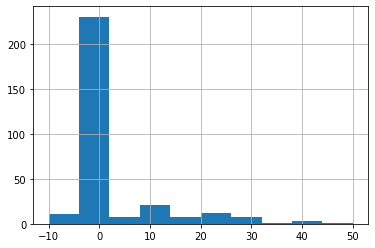

In [11]:
order_sheet.residuals.hist()

<AxesSubplot:>

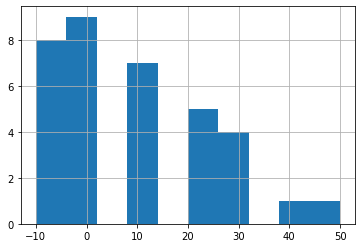

In [12]:
order_sheet[order_sheet[proposal_preds_column].astype(str) == "nan"].residuals.hist()

In [13]:
order_sheet.residuals.value_counts(normalize=True)

 0.0     0.766667
 10.0    0.070000
 20.0    0.030000
-10.0    0.026667
 5.0     0.023333
 30.0    0.023333
 15.0    0.023333
 40.0    0.010000
 25.0    0.010000
-5.0     0.010000
 35.0    0.003333
 50.0    0.003333
Name: residuals, dtype: float64

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


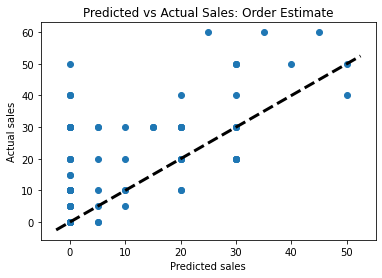

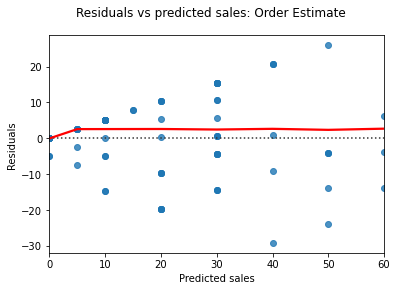

In [14]:
plot_preds(order_sheet['planned_order'], order_sheet['order_quantity'], 'Order Estimate')

In [15]:
mean_squared_error(order_sheet['planned_order'],order_sheet['order_quantity'],squared=False)

9.133272505880171

In [16]:
order_sheet.to_csv('../data/predictions/order_sheet.csv',index=False)